## Importing data

In [41]:
import pandas as pd
import numpy as np
df = pd.read_csv("ann_train.csv", index_col="id")
print(df)

         x    y       classification
id                                  
0      600   80  NORMAL SINUS RHYTHM
1      500   30   NARROW TACHYCARDIA
2      542   49   NARROW TACHYCARDIA
3      503   39   NARROW TACHYCARDIA
4      670   79  NORMAL SINUS RHYTHM
...    ...  ...                  ...
5954  1415  115    SINUS BRADYCARDIA
5955  1335  124     WIDE BRADYCARDIA
5956  1353   99    SINUS BRADYCARDIA
5957  1294  123     WIDE BRADYCARDIA
5958  1412   72   NARROW BRADYCARDIA

[5959 rows x 3 columns]


## Mapping outputs

In [42]:
df["classification"] = df["classification"].map(
    {

        "NORMAL SINUS RHYTHM": [1, 0, 0, 0, 0, 0, 0],
        "NARROW TACHYCARDIA": [0, 1, 0, 0, 0, 0, 0],
        "WIDE TACHYCARDIA": [0, 0, 1, 0, 0, 0, 0],
        "SINUS TACHYCARDIA": [0, 0, 0, 1, 0, 0, 0],
        "WIDE BRADYCARDIA": [0, 0, 0, 0, 1, 0, 0],
        "SINUS BRADYCARDIA": [0, 0, 0, 0, 0, 1, 0],
        "NARROW TACHYCARDIA": [0,0,0,0,0,0,1]
    }
)

## Data Cleaning

In [43]:
df.dropna(inplace=True)

## Data Normalization

In [44]:
df['x'] = (df['x'] - df['x'].mean()) / df['x'].std()
df['y'] = (df['y'] - df['y'].mean()) / df['y'].std()

## Making x,y

In [45]:
x = df[["x", "y"]]
y = np.array(df["classification"].tolist())

## Splitting data for training and testing

In [46]:
from sklearn.model_selection import train_test_split
import torch

x = torch.from_numpy(x.values).float()
y = torch.from_numpy(y).float()

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7, shuffle=True)

In [47]:
x_train, y_train

(tensor([[ 0.7634,  1.0574],
         [ 2.0155,  0.1728],
         [ 0.6261, -0.6592],
         ...,
         [-0.2664, -0.0589],
         [-0.5049, -0.2485],
         [-0.3350, -0.2590]]),
 tensor([[0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         ...,
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.]]))

## Declaring the Arrhythmia Classifier model

In [48]:
import torch.nn as nn


class Arrhythmia_classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(2, 8)
        self.act = nn.ReLU()
        self.output = nn.Linear(8, 7)

    def forward(self, x):
        x = self.act(self.hidden(x))
        x = self.output(x)
        return x


model = Arrhythmia_classifier()
model

Arrhythmia_classifier(
  (hidden): Linear(in_features=2, out_features=8, bias=True)
  (act): ReLU()
  (output): Linear(in_features=8, out_features=7, bias=True)
)

In [49]:
import torch.optim as optim
import numpy as np
import random

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.008)
random.seed(10)

In [50]:
import torch
import tqdm
import copy

n_epochs = 45
batch_size = 2
batches_per_epoch = len(x_train) // batch_size

best_acc = - np.inf   # init to negative infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []

for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    # set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # take a batch
            start = i * batch_size
            X_batch = x_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            #  TODO remove error here
            
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(
                loss=float(loss),
                acc=float(acc)
            )
    # set model in evaluation mode and run through the test set
    model.eval()
    y_pred = model(x_test)
    ce = loss_fn(y_pred, y_test)
    acc = (torch.argmax(y_pred, 1) == torch.argmax(y_test, 1)).float().mean()
    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)
    if acc > best_acc:
        best_acc = acc
        best_weights = copy.deepcopy(model.state_dict())
    print(f"Epoch {epoch} validation: Cross-entropy={ce}, Accuracy={acc}")

model.load_state_dict(best_weights)

Epoch 0: 100%|██████████| 1945/1945 [00:06<00:00, 282.41batch/s, acc=1, loss=0.088]   


Epoch 0 validation: Cross-entropy=0.21466383337974548, Accuracy=0.9358513355255127


Epoch 1: 100%|██████████| 1945/1945 [00:07<00:00, 271.44batch/s, acc=1, loss=0.0305]  


Epoch 1 validation: Cross-entropy=0.1518634408712387, Accuracy=0.9454436302185059


Epoch 2: 100%|██████████| 1945/1945 [00:07<00:00, 268.46batch/s, acc=1, loss=0.0202]  


Epoch 2 validation: Cross-entropy=0.12508833408355713, Accuracy=0.9508393406867981


Epoch 3: 100%|██████████| 1945/1945 [00:07<00:00, 273.99batch/s, acc=1, loss=0.0179]  


Epoch 3 validation: Cross-entropy=0.10912379622459412, Accuracy=0.9550359845161438


Epoch 4: 100%|██████████| 1945/1945 [00:08<00:00, 238.21batch/s, acc=1, loss=0.0145]  


Epoch 4 validation: Cross-entropy=0.0987624004483223, Accuracy=0.9622302055358887


Epoch 5: 100%|██████████| 1945/1945 [00:07<00:00, 272.60batch/s, acc=1, loss=0.0112]  


Epoch 5 validation: Cross-entropy=0.09180566668510437, Accuracy=0.9592326283454895


Epoch 6: 100%|██████████| 1945/1945 [00:07<00:00, 246.51batch/s, acc=1, loss=0.0064]  


Epoch 6 validation: Cross-entropy=0.08687718957662582, Accuracy=0.9598321318626404


Epoch 7: 100%|██████████| 1945/1945 [00:07<00:00, 253.30batch/s, acc=1, loss=0.00466] 


Epoch 7 validation: Cross-entropy=0.081721231341362, Accuracy=0.9634292721748352


Epoch 8: 100%|██████████| 1945/1945 [00:07<00:00, 255.87batch/s, acc=1, loss=0.00397] 


Epoch 8 validation: Cross-entropy=0.0781879723072052, Accuracy=0.9640287756919861


Epoch 9: 100%|██████████| 1945/1945 [00:07<00:00, 258.38batch/s, acc=1, loss=0.00316] 


Epoch 9 validation: Cross-entropy=0.07491105049848557, Accuracy=0.9652278423309326


Epoch 10: 100%|██████████| 1945/1945 [00:07<00:00, 258.43batch/s, acc=1, loss=0.00229] 


Epoch 10 validation: Cross-entropy=0.07225571572780609, Accuracy=0.9676259160041809


Epoch 11: 100%|██████████| 1945/1945 [00:07<00:00, 268.36batch/s, acc=1, loss=0.00176] 


Epoch 11 validation: Cross-entropy=0.07142066955566406, Accuracy=0.9652278423309326


Epoch 12: 100%|██████████| 1945/1945 [00:07<00:00, 262.90batch/s, acc=1, loss=0.00188] 


Epoch 12 validation: Cross-entropy=0.06992672383785248, Accuracy=0.9664268493652344


Epoch 13: 100%|██████████| 1945/1945 [00:07<00:00, 258.43batch/s, acc=1, loss=0.00181] 


Epoch 13 validation: Cross-entropy=0.06920356303453445, Accuracy=0.9670263528823853


Epoch 14: 100%|██████████| 1945/1945 [00:06<00:00, 281.71batch/s, acc=1, loss=0.0015]  


Epoch 14 validation: Cross-entropy=0.07122458517551422, Accuracy=0.9664268493652344


Epoch 15: 100%|██████████| 1945/1945 [00:07<00:00, 264.87batch/s, acc=1, loss=0.00173] 


Epoch 15 validation: Cross-entropy=0.07329773157835007, Accuracy=0.964628279209137


Epoch 16: 100%|██████████| 1945/1945 [00:07<00:00, 263.66batch/s, acc=1, loss=0.00204] 


Epoch 16 validation: Cross-entropy=0.07021568715572357, Accuracy=0.9670263528823853


Epoch 17: 100%|██████████| 1945/1945 [00:07<00:00, 272.04batch/s, acc=1, loss=0.00201] 


Epoch 17 validation: Cross-entropy=0.06932446360588074, Accuracy=0.9676259160041809


Epoch 18: 100%|██████████| 1945/1945 [00:07<00:00, 274.51batch/s, acc=1, loss=0.00198] 


Epoch 18 validation: Cross-entropy=0.06866761296987534, Accuracy=0.9688249230384827


Epoch 19: 100%|██████████| 1945/1945 [00:07<00:00, 270.54batch/s, acc=1, loss=0.00169] 


Epoch 19 validation: Cross-entropy=0.06790675967931747, Accuracy=0.9694244861602783


Epoch 20: 100%|██████████| 1945/1945 [00:07<00:00, 267.39batch/s, acc=1, loss=0.00145] 


Epoch 20 validation: Cross-entropy=0.06830541789531708, Accuracy=0.971222996711731


Epoch 21: 100%|██████████| 1945/1945 [00:07<00:00, 247.37batch/s, acc=1, loss=0.00124] 


Epoch 21 validation: Cross-entropy=0.06785529106855392, Accuracy=0.971222996711731


Epoch 22: 100%|██████████| 1945/1945 [00:07<00:00, 262.24batch/s, acc=1, loss=0.00105] 


Epoch 22 validation: Cross-entropy=0.06763413548469543, Accuracy=0.971222996711731


Epoch 23: 100%|██████████| 1945/1945 [00:07<00:00, 255.83batch/s, acc=1, loss=0.00087] 


Epoch 23 validation: Cross-entropy=0.06747943162918091, Accuracy=0.9730215668678284


Epoch 24: 100%|██████████| 1945/1945 [00:07<00:00, 247.70batch/s, acc=1, loss=0.000724]


Epoch 24 validation: Cross-entropy=0.0664980486035347, Accuracy=0.971222996711731


Epoch 25: 100%|██████████| 1945/1945 [00:06<00:00, 301.26batch/s, acc=1, loss=0.000616]


Epoch 25 validation: Cross-entropy=0.0671568363904953, Accuracy=0.9718225598335266


Epoch 26: 100%|██████████| 1945/1945 [00:06<00:00, 290.73batch/s, acc=1, loss=0.00052] 


Epoch 26 validation: Cross-entropy=0.0675516203045845, Accuracy=0.9718225598335266


Epoch 27: 100%|██████████| 1945/1945 [00:07<00:00, 265.46batch/s, acc=1, loss=0.000433]


Epoch 27 validation: Cross-entropy=0.0686710998415947, Accuracy=0.9718225598335266


Epoch 28: 100%|██████████| 1945/1945 [00:07<00:00, 258.57batch/s, acc=1, loss=0.000389]


Epoch 28 validation: Cross-entropy=0.062379077076911926, Accuracy=0.9742206335067749


Epoch 29: 100%|██████████| 1945/1945 [00:08<00:00, 236.37batch/s, acc=1, loss=0.000307]


Epoch 29 validation: Cross-entropy=0.06733029335737228, Accuracy=0.9730215668678284


Epoch 30: 100%|██████████| 1945/1945 [00:07<00:00, 267.71batch/s, acc=1, loss=0.000338]


Epoch 30 validation: Cross-entropy=0.05880742892622948, Accuracy=0.9766187071800232


Epoch 31: 100%|██████████| 1945/1945 [00:06<00:00, 298.48batch/s, acc=1, loss=0.00024] 


Epoch 31 validation: Cross-entropy=0.061269864439964294, Accuracy=0.9766187071800232


Epoch 32: 100%|██████████| 1945/1945 [00:06<00:00, 283.88batch/s, acc=1, loss=0.000286]


Epoch 32 validation: Cross-entropy=0.06043574586510658, Accuracy=0.9766187071800232


Epoch 33: 100%|██████████| 1945/1945 [00:06<00:00, 291.23batch/s, acc=1, loss=0.00026] 


Epoch 33 validation: Cross-entropy=0.054762426763772964, Accuracy=0.9790167808532715


Epoch 34: 100%|██████████| 1945/1945 [00:06<00:00, 293.42batch/s, acc=1, loss=0.000221]


Epoch 34 validation: Cross-entropy=0.05456147342920303, Accuracy=0.9790167808532715


Epoch 35: 100%|██████████| 1945/1945 [00:06<00:00, 288.38batch/s, acc=1, loss=0.00022] 


Epoch 35 validation: Cross-entropy=0.053193382918834686, Accuracy=0.9790167808532715


Epoch 36: 100%|██████████| 1945/1945 [00:06<00:00, 288.01batch/s, acc=1, loss=0.00019] 


Epoch 36 validation: Cross-entropy=0.053145017474889755, Accuracy=0.9784172773361206


Epoch 37: 100%|██████████| 1945/1945 [00:06<00:00, 282.48batch/s, acc=1, loss=0.000196]


Epoch 37 validation: Cross-entropy=0.0525243878364563, Accuracy=0.9790167808532715


Epoch 38: 100%|██████████| 1945/1945 [00:06<00:00, 287.24batch/s, acc=1, loss=0.000184]


Epoch 38 validation: Cross-entropy=0.050782736390829086, Accuracy=0.980215847492218


Epoch 39: 100%|██████████| 1945/1945 [00:06<00:00, 293.82batch/s, acc=1, loss=0.000199]


Epoch 39 validation: Cross-entropy=0.05353638529777527, Accuracy=0.980215847492218


Epoch 40: 100%|██████████| 1945/1945 [00:06<00:00, 293.90batch/s, acc=1, loss=0.000211]


Epoch 40 validation: Cross-entropy=0.05426342785358429, Accuracy=0.9796162843704224


Epoch 41: 100%|██████████| 1945/1945 [00:06<00:00, 289.33batch/s, acc=1, loss=0.000236]


Epoch 41 validation: Cross-entropy=0.05260579288005829, Accuracy=0.9790167808532715


Epoch 42: 100%|██████████| 1945/1945 [00:06<00:00, 300.48batch/s, acc=1, loss=0.000185]


Epoch 42 validation: Cross-entropy=0.05412901192903519, Accuracy=0.980215847492218


Epoch 43: 100%|██████████| 1945/1945 [00:06<00:00, 292.79batch/s, acc=1, loss=0.000104]


Epoch 43 validation: Cross-entropy=0.04548913985490799, Accuracy=0.9820144176483154


Epoch 44: 100%|██████████| 1945/1945 [00:06<00:00, 289.41batch/s, acc=1, loss=0.000108]

Epoch 44 validation: Cross-entropy=0.043976496905088425, Accuracy=0.9814148545265198


<All keys matched successfully>

## Visualizing entropy and accuracy

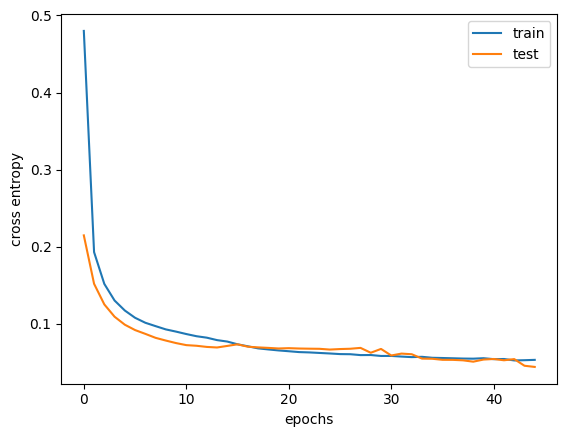

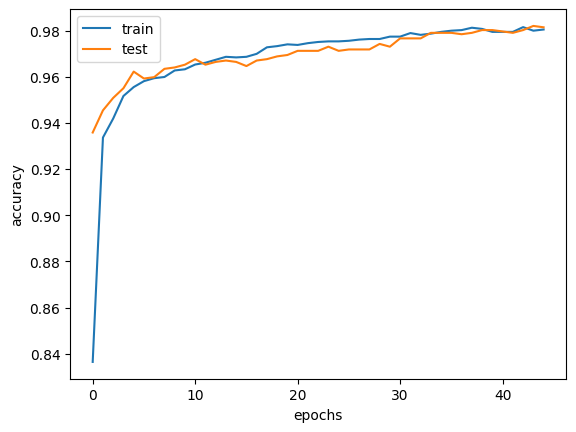

In [51]:
import matplotlib.pyplot as plt

plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [52]:
model.state_dict()

OrderedDict([('hidden.weight',
              tensor([[ 7.8428,  0.7134],
                      [-5.8642, -0.0900],
                      [ 1.8934,  1.1471],
                      [ 1.2212, -0.7334],
                      [-4.5824,  1.2923],
                      [-0.5082,  4.1457],
                      [-6.8287,  0.7017],
                      [ 0.0359, -7.9205]])),
             ('hidden.bias',
              tensor([-2.3693, -3.0648,  3.0698,  1.2950, -1.3336,  2.6480, -2.2916, -2.0285])),
             ('output.weight',
              tensor([[ -8.4668, -15.3879,   2.1031,   1.2559,  -2.4271,   1.4183,  -7.6113,
                         2.2005],
                      [ -1.1878,  -3.8474,  -3.0046,  -2.7263,  -3.7161,  -2.9312,  -4.5554,
                        -2.0881],
                      [ -2.2262,   1.0478,  -1.4490,  -3.4402,   1.9567,  -1.0784,   2.5005,
                       -17.9067],
                      [ -6.9339,   1.3118,  -0.1334,   0.3116,   2.1454,  -8.1933,   3.1045,

In [74]:
weightsAndBiases = model.state_dict()

## `load_model` 

In [76]:
# network structure, weights, biases and activation of output neurons of existing ANN
def load_model():
    network_structure = [2, 8, 7]  # input layer, hidden layer, output layer
    weights = np.array(
        [
            weightsAndBiases['hidden.weight'],
            weightsAndBiases['output.weight']
        ],
        dtype=object,
    )
    biases = np.array(
        [
            weightsAndBiases["hidden.bias"],
            weightsAndBiases["output.bias"],
        ]
    )
    classification_threshold = 0.5  # output activation needed to assign to class

    return network_structure, weights, biases, classification_threshold

## Declaring new class IF_Neuron

In [77]:

# Integrate and Fire Neuron Object
class IF_Neuron:
    def __init__(self, layer, weights, bias, steps, v_th):
        self.layer = layer  # Layer of Neuron
        self.weights = weights  # Weights
        self.bias = bias  # Bias

        # IF Properties
        self.steps = steps  # Number of steps for calculation
        self.v = np.empty([self.steps])  # Neuron Membrane Potential
        self.v[0] = 0  # Set start Value
        self.spikes = np.empty([self.steps])  # Output spike train
        self.n_spikes = 0  # Number of spikes
        self.v_th = v_th  # Threshold Voltage 

    def reset(self):  # Reset Neuron
        self.v = np.empty([self.steps])
        self.v[0] = 0
        self.spikes = np.empty([self.steps])
        self.n_spikes = 0

    def calculate(self, neuron_input):
        for i in range(self.steps):  # for every step
            if i > 0:  # not first element
                self.v[i] = self.v[i - 1]
            for j in range(len(neuron_input)):  # for every input channel
                if neuron_input[j][i]:  # if spike present
                    self.v[i] = self.v[i] + self.weights[j]
            self.v[i] = self.v[i] + self.bias
            if self.v[i] > self.v_th:  # if above threshold
                self.n_spikes += 1  # increase number of spikes
                self.spikes[i] = 1  # add spike to spike trace
                self.v[i] = self.v[i] - self.v_th  # difference reset
            else:  # add no spike to spike trace
                self.spikes[i] = 0

## Declaration for helper function `create_neuron`

In [78]:
def create_neurons(structure, weights, biases, steps, v_th, net_type):
    neuron_array = []  # array in which the neuron objects will be saved
    neuron_number = 0  # counter to initialize/create the neuron objects

    for layer in range(
        1, len(structure)
    ):  # for every layer (except layer 0 which is input)
        for neuron in range(structure[layer]):  # for number of neurons in layer
            # create SNN neurons
            neuron_array.append(
                IF_Neuron(
                    layer,
                    weights[neuron_number],
                    biases[neuron_number],
                    steps,
                    v_th[layer - 1],
                )
            )

    return neuron_array  # array of neuron objects

## `reset_neurons`

In [79]:
def reset_neurons(neuron_array):
    for neuron in neuron_array:
        neuron.reset()

## `calculate_pixel`

In [80]:
def calculate_pixel(network_structure, neuron_array, input_elements, net_type):
    max_activation = [0] * len(network_structure)
    for layer in range(1, len(network_structure)):  # for layer
        if layer == 1:  # if input layer
            neuron_input_array = input_elements  # get img values as input
        else:  # otherwise, get outputs of previous layer
            neuron_input_array = []
            for neuron in neuron_array:
                if neuron.layer == layer - 1:
                    neuron_input_array.append(neuron.spikes)  # spikes output

        for neuron in neuron_array:  # get all neurons of current layer and calculate
            if neuron.layer == layer:
                neuron.calculate(neuron_input_array)

    return max_activation

## `create_input_spike`

In [81]:
import random

steps = 5


def create_input_spike(input_array, steps):
    input_spike = np.zeros(steps)
    # rr_values_array=rr_values_array.astype(int)
    # for i, value in enumerate(rr_values_array):
    for l in range(steps):
        rnd = random.randrange(60, 120)
        # print(f"rnd:{rnd}")
        # print(f"input_array:{rr_values_array}")
        print(f"input_spike:{input_spike}")
        if rnd < input_array:
            input_spike[l] = 1

    return input_spike

## `create_input_spikes`

In [82]:
steps = 5


def create_input_spikes(input_array, steps):
    input_spikes = np.zeros(steps)
    for i in range(len(input_array)):
        for j in range(len(input_array[i])):
            if j == 0:
                pass_value1 = input_array[i][j]
                # pass_value1=pass_value1.astype(int)
                spikes1 = create_input_spike(pass_value1, steps)
                print(f"spikes1:{spikes1}")
            if j == 1:
                pass_value2 = input_array[i][j]
                # pass_value2=pass_value2.astype(int)
                spikes2 = create_input_spike(pass_value2, steps)
                print(f"spikes2:{spikes2}")
    return input_spikes

## `calculate_network`

In [83]:
def calculate_network(network_structure, neuron_array, input_array, steps, net_type):
    output_array = []
    max_activation = [0] * len(network_structure)
    max_activation[0] = 1
    number_of_total_spikes = 0

    for i, pixel in enumerate(input_array):  # for every pixel
        if (i + 1) / len(input_array) * 100 % 1 == 0:  # print status update
            print("\r", f"{int((i+1)/len(input_array)*100)}% done", end="")
            # if SNN
            reset_neurons(neuron_array)  # reset neurons
            input_spikes = create_input_spikes(pixel, steps)  # convert input to spikes
            calculate_pixel(network_structure, neuron_array, input_spikes, net_type)
        else:  # if ANN
            temp_max_act = calculate_pixel(
                network_structure, neuron_array, pixel, net_type
            )
            for j, element in enumerate(temp_max_act):
                max_activation[j] = max(max_activation[j], element)
        temp_out = []  # temporary array to store outputs
        for neuron in neuron_array:  # for every neuron
            number_of_total_spikes += neuron.n_spikes
            if neuron.layer == (len(network_structure) - 1):  # if output neur
                temp_out.append(
                    neuron.n_spikes
                )  # append number of spikes per output ne                     # append value of output neuron
        output_array.append(temp_out)  # append to output values
    print("\r", f"", end="")
    output_array = np.array(output_array)  # convert tu numpy array

    return output_array, max_activation

## End program

In [84]:
# from prg
# ! TODO fix error `input_array` is not defined
le1 = 5
for i in range(len(input_array)):
    spikes = np.vstack((spikes1, spikes2))
    print(f"spikes:{spikes}")
    for j in range(len(input_array[i])):
        if j == 0:
            pass_value1 = input_array[i][j]
            pass_value1 = pass_value1.astype(int)
            spikes1 = create_input_spikes(pass_value1, le1)
            # print(f"spikes1:{spikes1}")
        if j == 1:
            pass_value2 = input_array[i][j]
            pass_value2 = pass_value2.astype(int)
            spikes2 = create_input_spikes(pass_value2, le1)
        # print(f"spikes2:{spikes2}")
    # spikes=np.vstack((spikes1,spikes2))
    # print(f"spikes:{spikes}")

    print()

NameError: name 'input_array' is not defined